In [1]:
import numpy as np

import jax
import jax.numpy as jnp

from kernel_sca_inducing_points import *

Text(0.5, 0.92, '0.43157658')

<Figure size 640x480 with 0 Axes>

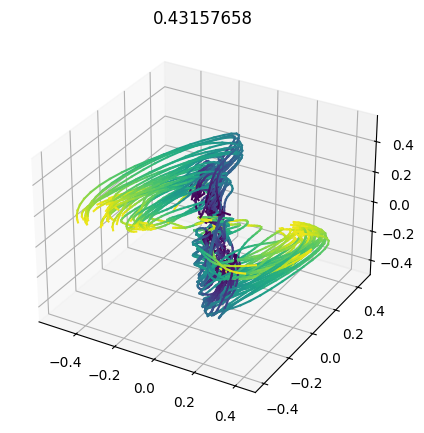

In [3]:
A = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/A_softNormMax_centerFalse.npy')
X = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/X_softNormMax_centerFalse.npy')
K, N, T = X.shape

params = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/params_3d_gaussian.npy', allow_pickle=True).tolist()

kernel_function = K_X_Y_squared_exponential
d = 3
c = 30
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, H_K_A_u  = get_alpha(params, A, X, kernel_function, d)
alpha_tilde, u, l2, scale = get_params(params, kernel_function=kernel_function)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)
plt.figure()
plot_3D(Y)
plt.title(compute_S_all_pairs(Y))

In [4]:



L = jnp.linalg.cholesky(K_u_u + jnp.identity(c) * 1e-5)
Q_, R = jnp.linalg.qr(H_K_A_u, mode='reduced')                                                                                       
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde, mode='reduced') 
alpha = jnp.einsum('ij,jm->im', Q_, solve_triangular(R.T, jnp.dot(L, alpha_tilde_QR), lower=True))   

K_A_A = kernel_function(A, A, l2=l2, scale=scale)
K_A_A_reshaped = K_A_A.reshape(K, T, K, T)
mean = jnp.mean(K_A_A_reshaped, axis=(0,2), keepdims=True)   
K_A_A_tilde = (K_A_A_reshaped - mean).reshape(K*T, K*T)       

var_explained = jnp.trace(alpha.T @ K_A_A_tilde @ alpha) / jnp.trace(K_A_A_tilde)
print(var_explained)


0.0012770556


In [ ]:
X_reshaped = X.swapaxes(1,2).reshape(-1, N)
full_X_var = jnp.sum(jnp.var(X_reshaped, axis=0))

Y_reshaped = Y.swapaxes(1,2).reshape(-1, d)
full_Y_var = jnp.sum(jnp.var(Y_reshaped, axis=0))

full_Y_var/full_X_var

In [29]:
def var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u):
    return  np.trace( K_u_u_K_u_A_alpha_H.T @ K_u_u_K_u_A_alpha_H / np.trace(H_K_A_u @ K_u_u @ H_K_A_u.T )   ) 

print(var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u))

1.6610733e-05
